# パノラマ写真の作り方

参考: https://news.mynavi.jp/article/computer_vision-28/
参考: https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/
参考: http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html#feature-homography

## 入力画像が2枚のときの処理

![パノラマ写真](https://www.pyimagesearch.com/wp-content/uploads/2016/01/bryce_result_02-1024x811.jpg "2枚の写真をつなげる")

1. キーポイントの検出と局所特徴記述子の抽出: 2つの画像から局所特徴量記述子を抽出する。位置不変性をもつ特徴記述子(SIFT, SURFなど）を用いる。
2. 位置合わせ: 2つの画像を1つに張り合わせるため、キーポイントのマッチングを行う。
3. 移動量や変形量の推定: 点対応からその座標系モデル上での「移動量(平行移動量、回転量など)」と「画像の変形量(ホモグラフィ)」を推定。このためにRANSACアルゴリズムが使える。
4. 合成処理: ワーピング変形を行い、最終画像が自然な画像になるように画素値合成処理を行う。これにより2枚の入力画像から1つのパノラマ画像が完成。

注意: imutils モジュールを用いるので、 pip install imutils　を実行しておくこと
OpenCV2とOpenCV3ではキーポイント検出と位置不変記述子の扱いが異なるので、つぎのようにしてどちらのバージョンを使っているかをしらべることができる。

In [6]:
import cv2
cv2.__version__

'3.4.2'

In [7]:
import imutils
print(imutils.is_cv3())

True


In [12]:
# 出典: https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/
# import the necessary packages
import numpy as np
import imutils
import cv2
 
class Stitcher:
	def __init__(self):
		# determine if we are using OpenCV v3.X
		self.isv3 = imutils.is_cv3()
	def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
		# unpack the images, then detect keypoints and extract
		# local invariant descriptors from them
		(imageB, imageA) = images
		(kpsA, featuresA) = self.detectAndDescribe(imageA)
		(kpsB, featuresB) = self.detectAndDescribe(imageB)
 
		# match features between the two images
		M = self.matchKeypoints(kpsA, kpsB,
			featuresA, featuresB, ratio, reprojThresh)
 
		# if the match is None, then there aren't enough matched
		# keypoints to create a panorama
		if M is None:
			return None
		# otherwise, apply a perspective warp to stitch the images
		# together
		(matches, H, status) = M
		result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
		result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
 
		# check to see if the keypoint matches should be visualized
		if showMatches:
			vis = self.drawMatches( imageA,  imageB,  kpsA, kpsB, matches, status)
 
			# return a tuple of the stitched image and the
			# visualization
			return (result, vis)
 
		# return the stitched image
		return result
	def detectAndDescribe(self, image):
		# convert the image to grayscale
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
		# check to see if we are using OpenCV 3.X
		if self.isv3:
			# detect and extract features from the image
			descriptor = cv2.xfeatures2d.SIFT_create()
			(kps, features) = descriptor.detectAndCompute(image, None)
 
		# otherwise, we are using OpenCV 2.4.X
		else:
			# detect keypoints in the image
			detector = cv2.FeatureDetector_create("SIFT")
			kps = detector.detect(gray)
 
			# extract features from the image
			extractor = cv2.DescriptorExtractor_create("SIFT")
			(kps, features) = extractor.compute(gray, kps)
 
		# convert the keypoints from KeyPoint objects to NumPy
		# arrays
		kps = np.float32([kp.pt for kp in kps])
 
		# return a tuple of keypoints and features
		return (kps, features)

	def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
		ratio, reprojThresh):
		# compute the raw matches and initialize the list of actual
		# matches
		matcher = cv2.DescriptorMatcher_create("BruteForce")
		rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
		matches = []
 
		# loop over the raw matches
		for m in rawMatches:
			# ensure the distance is within a certain ratio of each
			# other (i.e. Lowe's ratio test)
			if len(m) == 2 and m[0].distance < m[1].distance * ratio:
				matches.append((m[0].trainIdx, m[0].queryIdx))
		# computing a homography requires at least 4 matches
		if len(matches) > 4:
			# construct the two sets of points
			ptsA = np.float32([kpsA[i] for (_, i) in matches])
			ptsB = np.float32([kpsB[i] for (i, _) in matches])
 
			# compute the homography between the two sets of points
			(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)
 
			# return the matches along with the homograpy matrix
			# and status of each matched point
			return (matches, H, status)
 
		# otherwise, no homograpy could be computed
		return None

	def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
		# initialize the output visualization image
		(hA, wA) = imageA.shape[:2]
		(hB, wB) = imageB.shape[:2]
		vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
		vis[0:hA, 0:wA] = imageA
		vis[0:hB, wA:] = imageB
 
		# loop over the matches
		for ((trainIdx, queryIdx), s) in zip(matches, status):
			# only process the match if the keypoint was successfully
			# matched
			if s == 1:
				# draw the match
				ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
				ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
				cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
 
		# return the visualization
		return vis

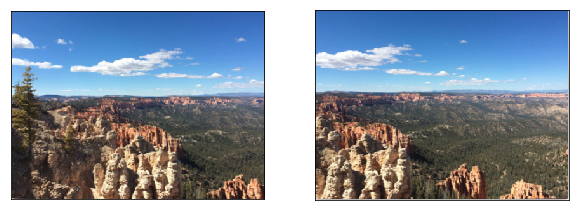

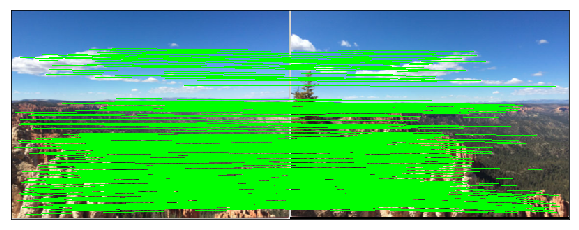

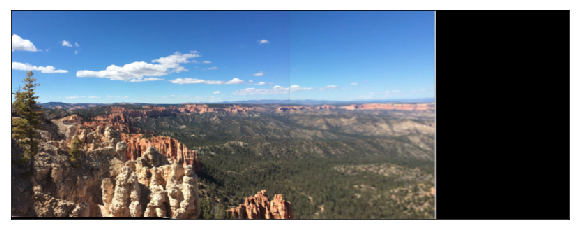

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
imageA = cv2.imread("Figs/Panorama-1.png")
imageB = cv2.imread("Figs/Panorama-2.png")

imageA = cv2.cvtColor(imageA,cv2.COLOR_RGB2BGR)
imageB = cv2.cvtColor(imageB,cv2.COLOR_RGB2BGR)
imageA = imutils.resize(imageA, width=400)
imageB = imutils.resize(imageB, width=400)
# stitch the images together to create a panorama
stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)
 
# show the images

plt.figure(figsize=(10,10))
plt.subplot(1,2,1) ; plt.imshow(imageA), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2) ; plt.imshow(imageB), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(vis), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(result), plt.xticks([]), plt.yticks([])
plt.show()

写真の明るさに差が少ないので、つなぎ目がはっきりわかるものの、よさそうな写真に仕上がっている。 Adrianはオートフォーカスを使っているので写真によって微妙に焦点が違うことがつなぎ目の原因として、 固定焦点でとった写真を使うほうが綺麗にできると書いている。

また、2つの写真の輝度を合わせる（正規化する）という工夫も必要となろう。

上のプログラムを一つにまとめたもの: http://lang.sist.chukyo-u.ac.jp/Classes/ComputerVisiotn/stitcher.py

なお、2台のカメラからの画像をリアルタイムにつなぎあわせる(stitchする)ことも可能である。

2台のカメラからの画像をリアルタイムにつなぎあわせる(stitchする)ことも可能である。

参考: https://www.pyimagesearch.com/2016/01/25/real-time-panorama-and-image-stitching-with-opencv/

## 修正版
キーポイントの対応点を表示する図が、左右入れ違っているという指摘が合ったので、それ用にコードを書き換えました。

In [14]:
# 出典: https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/
# import the necessary packages
import numpy as np
import imutils
import cv2
 
class Stitcher2:
	def __init__(self):
		# determine if we are using OpenCV v3.X
		self.isv3 = imutils.is_cv3()
	def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
		# unpack the images, then detect keypoints and extract
		# local invariant descriptors from them
		(imageB, imageA) = images
		(kpsA, featuresA) = self.detectAndDescribe(imageA)
		(kpsB, featuresB) = self.detectAndDescribe(imageB)
 
		# match features between the two images
		M = self.matchKeypoints(kpsA, kpsB,
			featuresA, featuresB, ratio, reprojThresh)
 
		# if the match is None, then there aren't enough matched
		# keypoints to create a panorama
		if M is None:
			return None
		# otherwise, apply a perspective warp to stitch the images
		# together
		(matches, H, status) = M
		result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
		result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
 
		# check to see if the keypoint matches should be visualized
		if showMatches:
			vis = self.drawMatches( imageA,  imageB,  kpsA, kpsB, matches, status)
 
			# return a tuple of the stitched image and the
			# visualization
			return (result, vis)
 
		# return the stitched image
		return result
	def detectAndDescribe(self, image):
		# convert the image to grayscale
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
		# check to see if we are using OpenCV 3.X
		if self.isv3:
			# detect and extract features from the image
			descriptor = cv2.xfeatures2d.SIFT_create()
			(kps, features) = descriptor.detectAndCompute(image, None)
 
		# otherwise, we are using OpenCV 2.4.X
		else:
			# detect keypoints in the image
			detector = cv2.FeatureDetector_create("SIFT")
			kps = detector.detect(gray)
 
			# extract features from the image
			extractor = cv2.DescriptorExtractor_create("SIFT")
			(kps, features) = extractor.compute(gray, kps)
 
		# convert the keypoints from KeyPoint objects to NumPy
		# arrays
		kps = np.float32([kp.pt for kp in kps])
 
		# return a tuple of keypoints and features
		return (kps, features)

	def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
		ratio, reprojThresh):
		# compute the raw matches and initialize the list of actual
		# matches
		matcher = cv2.DescriptorMatcher_create("BruteForce")
		rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
		matches = []
 
		# loop over the raw matches
		for m in rawMatches:
			# ensure the distance is within a certain ratio of each
			# other (i.e. Lowe's ratio test)
			if len(m) == 2 and m[0].distance < m[1].distance * ratio:
				matches.append((m[0].trainIdx, m[0].queryIdx))
		# computing a homography requires at least 4 matches
		if len(matches) > 4:
			# construct the two sets of points
			ptsA = np.float32([kpsA[i] for (_, i) in matches])
			ptsB = np.float32([kpsB[i] for (i, _) in matches])
 
			# compute the homography between the two sets of points
			(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)
 
			# return the matches along with the homograpy matrix
			# and status of each matched point
			return (matches, H, status)
 
		# otherwise, no homograpy could be computed
		return None

	def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
		# initialize the output visualization image
		(hA, wA) = imageA.shape[:2]
		(hB, wB) = imageB.shape[:2]
		vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
		vis[0:hB, 0:wB] = imageB
		vis[0:hA, wB:] = imageA
 
		# loop over the matches
		for ((trainIdx, queryIdx), s) in zip(matches, status):
			# only process the match if the keypoint was successfully
			# matched
			if s == 1:
				# draw the match
				ptA = (int(kpsA[queryIdx][0]) + wB, int(kpsA[queryIdx][1]))
				ptB = (int(kpsB[trainIdx][0]) , int(kpsB[trainIdx][1]))
				cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
 
		# return the visualization
		return vis

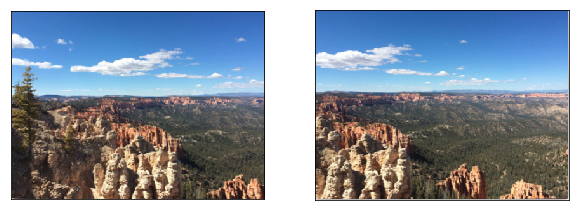

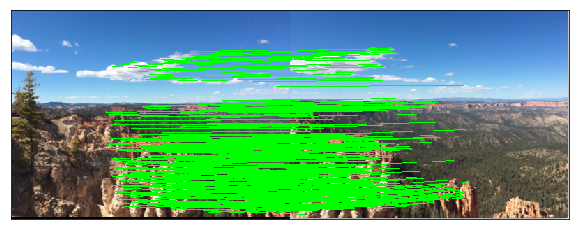

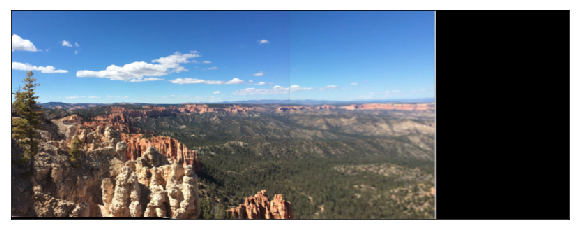

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
imageA = cv2.imread("Figs/Panorama-1.png")
imageB = cv2.imread("Figs/Panorama-2.png")

imageA = cv2.cvtColor(imageA,cv2.COLOR_RGB2BGR)
imageB = cv2.cvtColor(imageB,cv2.COLOR_RGB2BGR)
imageA = imutils.resize(imageA, width=400)
imageB = imutils.resize(imageB, width=400)
# stitch the images together to create a panorama
stitcher = Stitcher2()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)
 
# show the images

plt.figure(figsize=(10,10))
plt.subplot(1,2,1) ; plt.imshow(imageA), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2) ; plt.imshow(imageB), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(vis), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(result), plt.xticks([]), plt.yticks([])
plt.show()

# OpenCVのStitcherクラス
OpenCVにStitcherクラスがあるのを発見した。

In [1]:
import cv2
trial=cv2.createStitcher()
help(trial)

Help on Stitcher object:

class Stitcher(builtins.object)
 |  Methods defined here:
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  composePanorama(...)
 |      composePanorama([, pano]) -> retval, pano
 |      .   @overload
 |  
 |  compositingResol(...)
 |      compositingResol() -> retval
 |      .
 |  
 |  estimateTransform(...)
 |      estimateTransform(images) -> retval
 |      .   @overload
 |  
 |  panoConfidenceThresh(...)
 |      panoConfidenceThresh() -> retval
 |      .
 |  
 |  registrationResol(...)
 |      registrationResol() -> retval
 |      .   @brief Creates a Stitcher configured in one of the stitching modes.
 |      .   
 |      .   @param mode Scenario for stitcher operation. This is usually determined by source of images
 |      .   to stitch and their transformation. Default parameters will be chosen for operation in given
 |      .   scenario.
 |      .   @param try_use_gpu Flag indicating whether GPU should be used whenever it's possible.
 |    

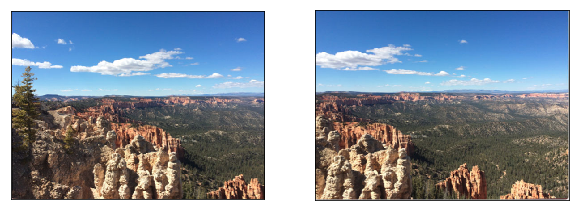

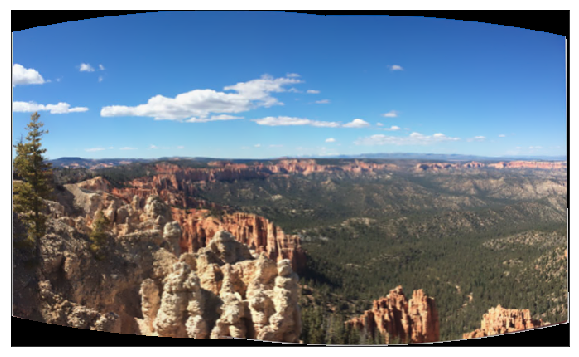

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

imageA = cv2.imread("Figs/Panorama-1.png")
imageB = cv2.imread("Figs/Panorama-2.png")

imageA = cv2.cvtColor(imageA,cv2.COLOR_RGB2BGR)
imageB = cv2.cvtColor(imageB,cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1) ; plt.imshow(imageA), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2) ; plt.imshow(imageB), plt.xticks([]), plt.yticks([])
plt.show()

# imageA = imutils.resize(imageA, width=400)
# imageB = imutils.resize(imageB, width=400)
# stitch the images together to create a panorama
stitcher = cv2.createStitcher()

result = stitcher.stitch((imageA, imageB))

# show the images

plt.figure(figsize=(10,10))
# Caution: result=(retval, pano)
plt.imshow(result[1]), plt.xticks([]), plt.yticks([])
plt.show()

大変スムーズな写真に仕上がっている